<a href="https://colab.research.google.com/github/vishnuvryeruva/GMM-Hierarchichal/blob/main/GMM_%26_Hierarchichal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture as GMM

GMM

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [3]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1]

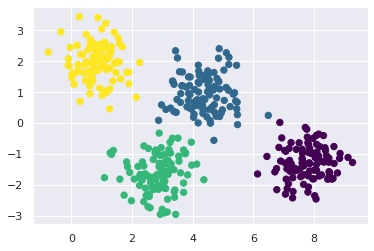

In [4]:
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [5]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.463 0.537 0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.   ]]


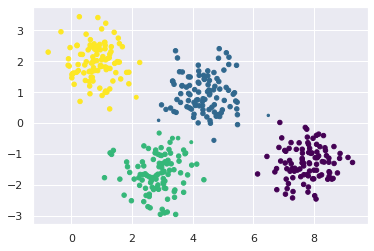

In [7]:
size = 20 * probs.max(1) ** 2
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

In [8]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

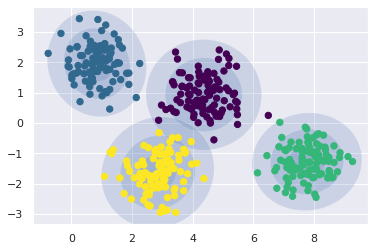

In [9]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)

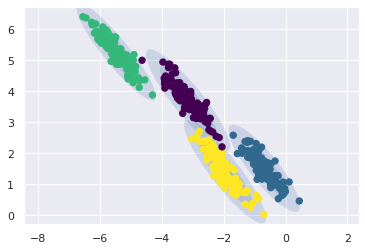

In [10]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X_stretched)

With IRIS

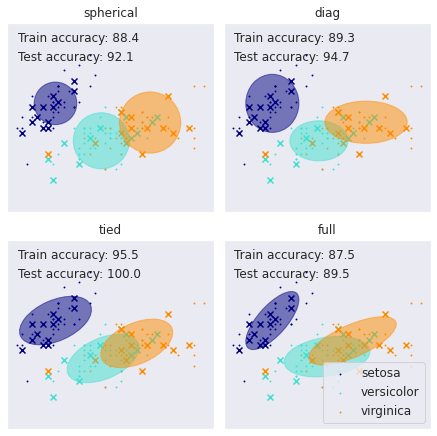

In [11]:

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
colors = ["navy", "turquoise", "darkorange"]


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], 180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")


iris = datasets.load_iris()
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(
            data[:, 0], data[:, 1], s=0.8, color=color, label=iris.target_names[n]
        )
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc="lower right", prop=dict(size=12))


plt.show()

Hierarchical

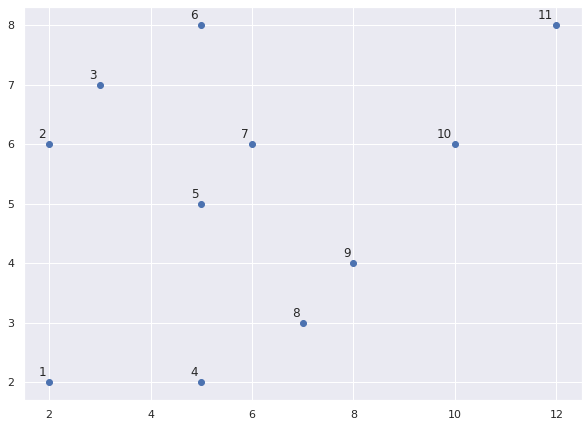

In [12]:
import numpy as np
X = np.array([[2,2],[2,6],[3,7],[5,2],[5,5],[5,8],[6,6],[7,3],[8,4],[10,6],[12,8]])

import matplotlib.pyplot as plt

labels = range(1, 12)
plt.figure(figsize=(10, 7))
plt.subplots_adjust(bottom=0.1)
plt.scatter(X[:,0],X[:,1], label='True Position')
for label, x, y in zip(labels, X[:, 0], X[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()


 Single Link Cluster 



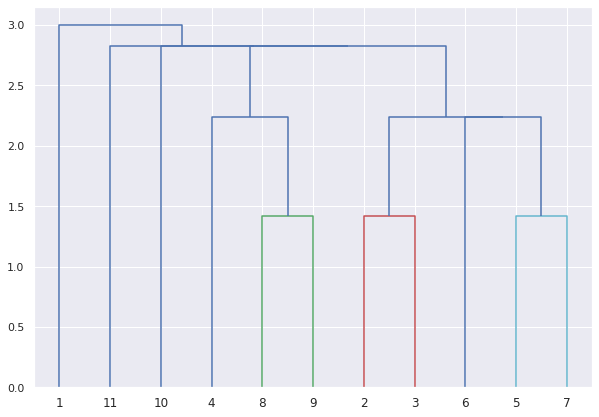


 Complete Link cluster 



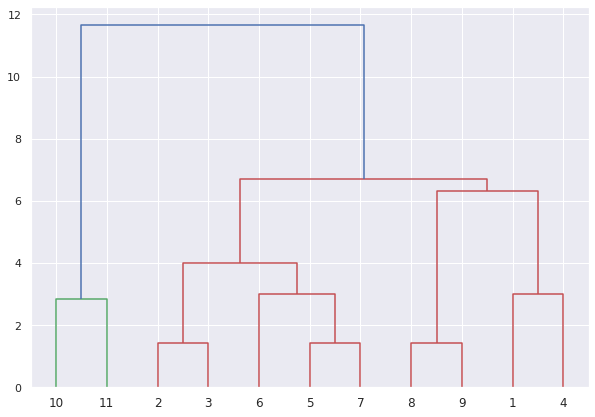


 Average Link cluster 



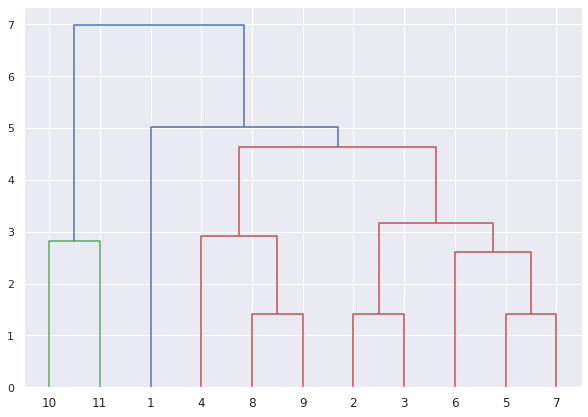

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

print ("\n Single Link Cluster \n") 
linked = linkage(X, 'single')

labelList = range(1, 12)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

print ("\n Complete Link cluster \n") 
linked_complete = linkage(X, 'complete') 

labelList = range(1, 12)

plt.figure(figsize=(10, 7))
dendrogram(linked_complete,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

print ("\n Average Link cluster \n") 
linked_complete = linkage(X, 'average') 

labelList = range(1, 12)

plt.figure(figsize=(10, 7))
dendrogram(linked_complete,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [14]:
index = [('California', 2000), ('California', 2010),
         ('New York', 2000), ('New York', 2010),
         ('Texas', 2000), ('Texas', 2010)]
populations = [33871648, 37253956,
               18976457, 19378102,
               20851820, 25145561]
pop = pd.Series(populations, index=index)
pop

(California, 2000)    33871648
(California, 2010)    37253956
(New York, 2000)      18976457
(New York, 2010)      19378102
(Texas, 2000)         20851820
(Texas, 2010)         25145561
dtype: int64

In [15]:
index = pd.MultiIndex.from_tuples(index)
index

MultiIndex([('California', 2000),
            ('California', 2010),
            (  'New York', 2000),
            (  'New York', 2010),
            (     'Texas', 2000),
            (     'Texas', 2010)],
           )

In [16]:
pop = pop.reindex(index)
pop

California  2000    33871648
            2010    37253956
New York    2000    18976457
            2010    19378102
Texas       2000    20851820
            2010    25145561
dtype: int64

In [17]:
data = {('California', 2000): 33871648,
        ('California', 2010): 37253956,
        ('Texas', 2000): 20851820,
        ('Texas', 2010): 25145561,
        ('New York', 2000): 18976457,
        ('New York', 2010): 19378102}
pd.Series(data)

California  2000    33871648
            2010    37253956
Texas       2000    20851820
            2010    25145561
New York    2000    18976457
            2010    19378102
dtype: int64